In [ ]:
pip install sentence-transformers

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
import os
from tqdm import tqdm
import pickle
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib_venn import venn2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/Speech-NER/train.pkl", 'rb') as file:
    train = pickle.load(file)

with open("/content/drive/MyDrive/Speech-NER/test.pkl", 'rb') as file:
    test = pickle.load(file)

with open("/content/drive/MyDrive/Speech-NER/aug.pkl", 'rb') as file:
    aug = pickle.load(file)

with open("/content/augmented_data_formatted_v1.pkl", 'rb') as file:
    aug1 = pickle.load(file)

with open("/content/augmented_data_formatted_v2.pkl", 'rb') as file:
    aug2 = pickle.load(file)

with open("/content/augmented_data_formatted_v3.pkl", 'rb') as file:
    aug3 = pickle.load(file)

with open("/content/augmented_data_formatted_v4.pkl", 'rb') as file:
    aug4 = pickle.load(file)

with open("/content/augmented_data_formatted_v5.pkl", 'rb') as file:
    aug5 = pickle.load(file)

with open("/content/augmented_data_formatted_v6.pkl", 'rb') as file:
    aug6 = pickle.load(file)

### Analysing the similarity between the structure of Augmented and Train sentences by getting the Cosine Similarity of their embeddings

In [ ]:
def replace_tags_with_pad(sentences, tags_list):
    new_sentences = []

    for sentence, tags in zip(sentences, tags_list):
        sentence_chars = list(sentence)

        for tag in tags[::-1]:
            start = tag['start']
            end = tag['end']
            sentence_chars[start:end] = "[PAD]"

        new_sentence = ''.join(sentence_chars)
        new_sentences.append(new_sentence)

    return new_sentences

train_wo_tags = replace_tags_with_pad(train[0], train[1])
aug_wo_tags = replace_tags_with_pad(aug[0], aug[1])
aug1_wo_tags = replace_tags_with_pad(aug1[0], aug1[1])
aug2_wo_tags = replace_tags_with_pad(aug2[0], aug2[1])
aug3_wo_tags = replace_tags_with_pad(aug3[0], aug3[1])
aug4_wo_tags = replace_tags_with_pad(aug4[0], aug4[1])
aug5_wo_tags = replace_tags_with_pad(aug5[0], aug5[1])
aug6_wo_tags = replace_tags_with_pad(aug6[0], aug6[1])

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

list1 = train_wo_tags
list2 = aug_wo_tags
list3 = aug1_wo_tags
list4 = aug2_wo_tags
list5 = aug3_wo_tags
list6 = aug4_wo_tags
list7 = aug5_wo_tags
list8 = aug6_wo_tags

all_sentences = list1 + list2 + list3 + list4 + list5 + list6 + list7 + list8
embeddings = model.encode(all_sentences)

train_embeddings = embeddings[:len(list1)]
aug_embeddings = embeddings[len(list1):len(list1)+len(list2)]
aug1_embeddings = embeddings[len(list1)+len(list2):len(list1)+len(list2)+len(list3)]
aug2_embeddings = embeddings[len(list1)+len(list2)+len(list3):len(list1)+len(list2)+len(list3)+len(list4)]
aug3_embeddings = embeddings[len(list1)+len(list2)+len(list3)+len(list4):len(list1)+len(list2)+len(list3)+len(list4)+len(list5)]
aug4_embeddings = embeddings[len(list1)+len(list2)+len(list3)+len(list4)+len(list5):len(list1)+len(list2)+len(list3)+len(list4)+len(list5)+len(list6)]
aug5_embeddings = embeddings[len(list1)+len(list2)+len(list3)+len(list4)+len(list5)+len(list6): len(list1)+len(list2)+len(list3)+len(list4)+len(list5)+len(list6)+len(list7)]
aug6_embeddings = embeddings[len(list1)+len(list2)+len(list3)+len(list4)+len(list5)+len(list6)+len(list7):]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
assert len(train_embeddings) == len(list1)
assert len(aug_embeddings) == len(list2)
assert len(aug1_embeddings) == len(list3)
assert len(aug2_embeddings) == len(list4)
assert len(aug3_embeddings) == len(list5)
assert len(aug4_embeddings) == len(list6)
assert len(aug5_embeddings) == len(list7)
assert len(aug6_embeddings) == len(list8)

In [ ]:
def similarity_analysis(aug_embeddings):
  similarity_list = []
  for aug_emb in tqdm(aug_embeddings):
      similarities = cosine_similarity([aug_emb], train_embeddings)
      similarity_list.append(similarities[0].tolist())

  similarity_list_train = []

  for i, train_emb in enumerate(tqdm(train_embeddings)):
      similarities = cosine_similarity([train_emb], train_embeddings)
      similarities = similarities[0].tolist()
      similarities.pop(i)
      similarity_list_train.append(similarities)

  similarity_max_aug = []
  for i in similarity_list:
    similarity_max_aug.append(max(i))

  similarity_max_train = []
  for i in similarity_list_train:
    similarity_max_train.append(max(i))

  similarity_max_aug = np.array(similarity_max_aug)
  similarity_max_train = np.array(similarity_max_train)

  mean_aug = np.mean(similarity_max_aug)
  std_aug = np.std(similarity_max_aug)
  mean_train = np.mean(similarity_max_train)
  std_train = np.std(similarity_max_train)

  print("Augmented Data - Maximum Similarities")
  print(f"Mean: {mean_aug:.4f}, Standard Deviation: {std_aug:.4f}")

  print("\nTraining Data - Maximum Similarities")
  print(f"Mean: {mean_train:.4f}, Standard Deviation: {std_train:.4f}")

  plt.figure(figsize=(12, 6))

  plt.hist(similarity_max_aug, bins=40, alpha=0.7, label='Augmented Data')
  plt.hist(similarity_max_train, bins=40, alpha=0.7, label='Training Data')

  plt.title('Histogram of Maximum Cosine Similarities')
  plt.xlabel('Cosine Similarity')
  plt.ylabel('Frequency')
  plt.legend(loc='upper right')

  plt.show()
  return mean_aug, std_aug

100%|██████████| 788/788 [00:00<00:00, 1088.99it/s]


Augmented Data - Maximum Similarities
Mean: 0.5826, Standard Deviation: 0.1303

Training Data - Maximum Similarities
Mean: 0.7150, Standard Deviation: 0.1853


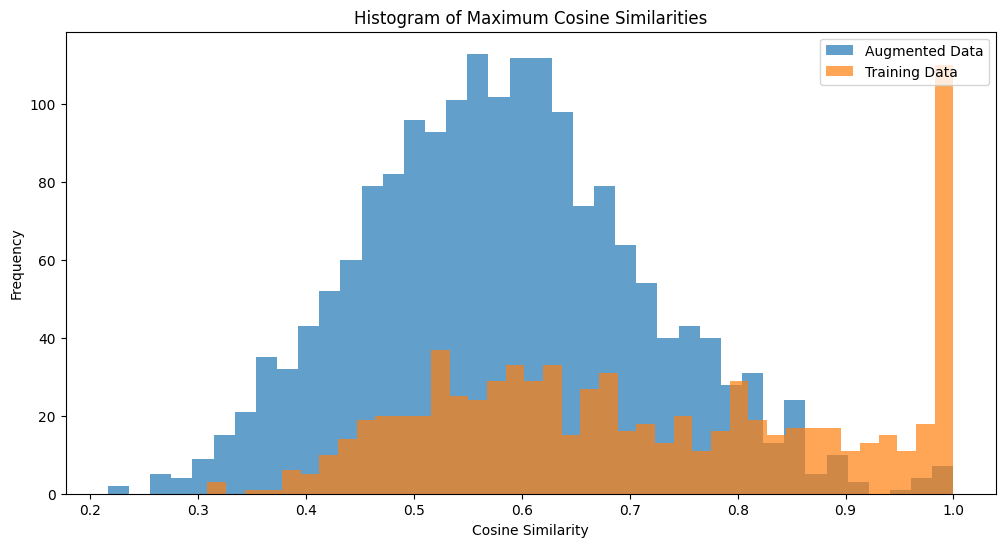

100%|██████████| 788/788 [00:00<00:00, 1111.33it/s]


Augmented Data - Maximum Similarities
Mean: 0.6966, Standard Deviation: 0.1122

Training Data - Maximum Similarities
Mean: 0.7150, Standard Deviation: 0.1853


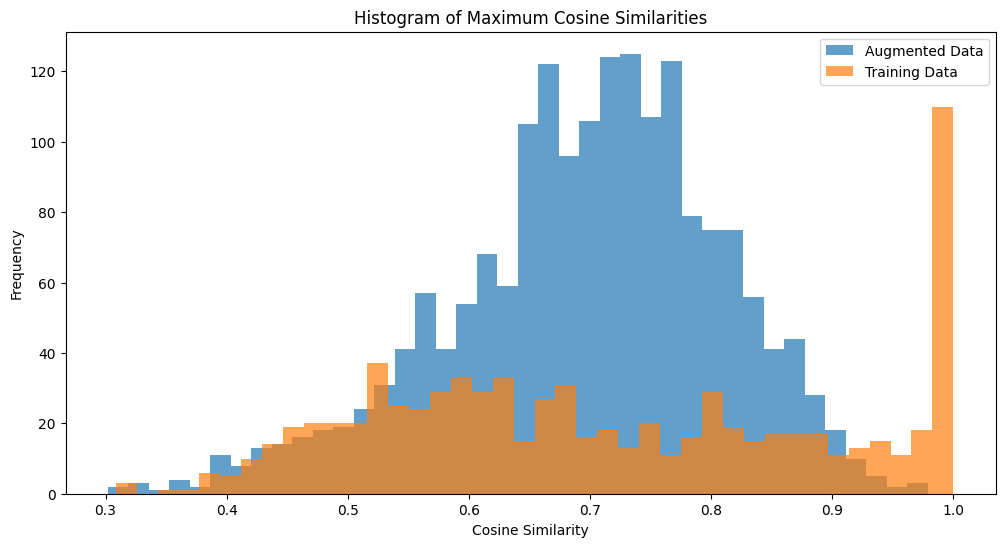

100%|██████████| 788/788 [00:00<00:00, 1111.68it/s]


Augmented Data - Maximum Similarities
Mean: 0.6791, Standard Deviation: 0.1291

Training Data - Maximum Similarities
Mean: 0.7150, Standard Deviation: 0.1853


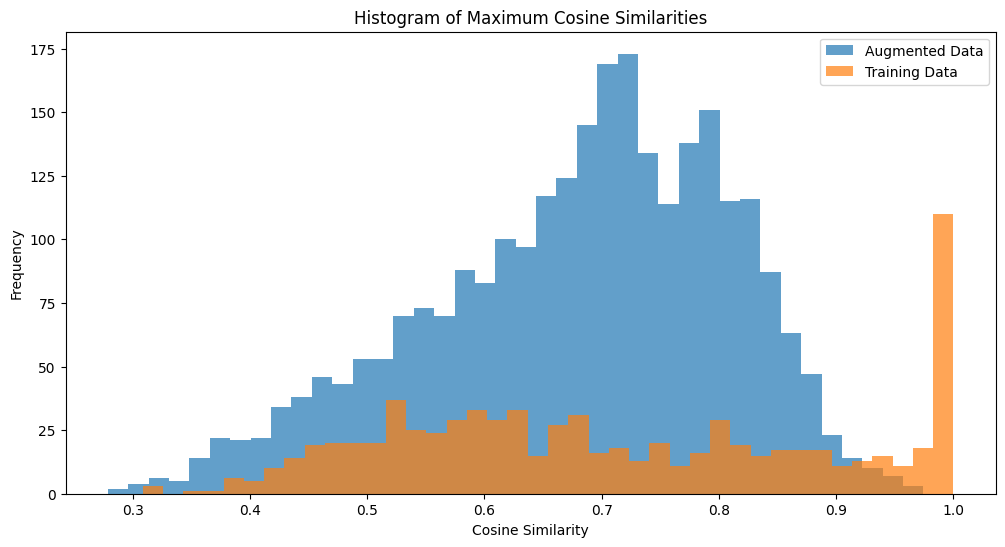

100%|██████████| 788/788 [00:00<00:00, 1061.61it/s]


Augmented Data - Maximum Similarities
Mean: 0.6938, Standard Deviation: 0.1245

Training Data - Maximum Similarities
Mean: 0.7150, Standard Deviation: 0.1853


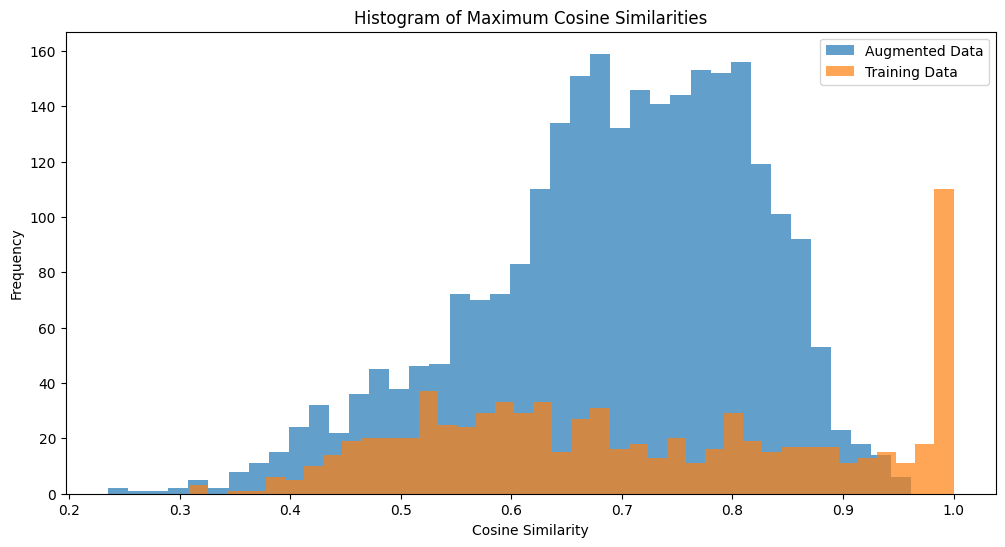

100%|██████████| 788/788 [00:00<00:00, 1080.45it/s]


Augmented Data - Maximum Similarities
Mean: 0.7115, Standard Deviation: 0.1165

Training Data - Maximum Similarities
Mean: 0.7150, Standard Deviation: 0.1853


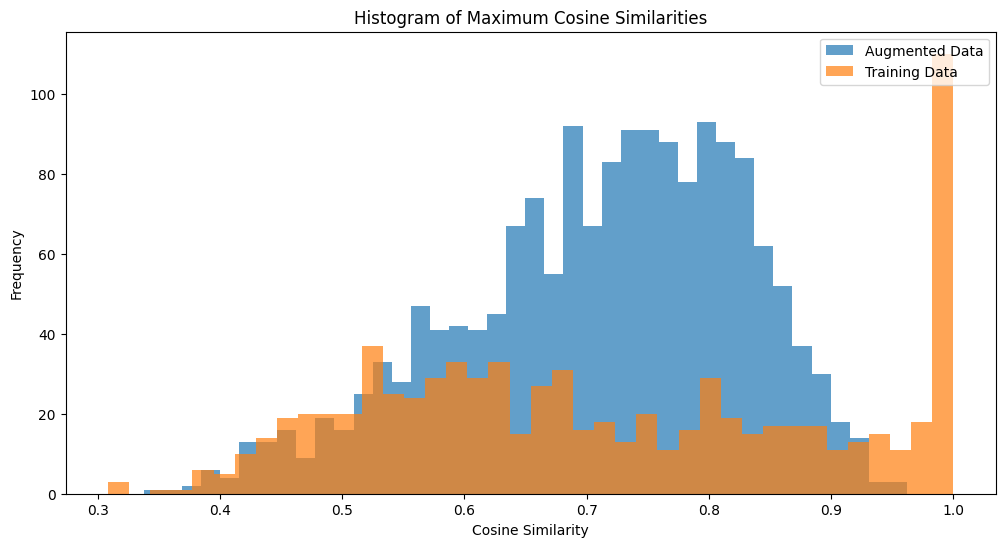

100%|██████████| 788/788 [00:01<00:00, 619.84it/s]


Augmented Data - Maximum Similarities
Mean: 0.6257, Standard Deviation: 0.1219

Training Data - Maximum Similarities
Mean: 0.7150, Standard Deviation: 0.1853


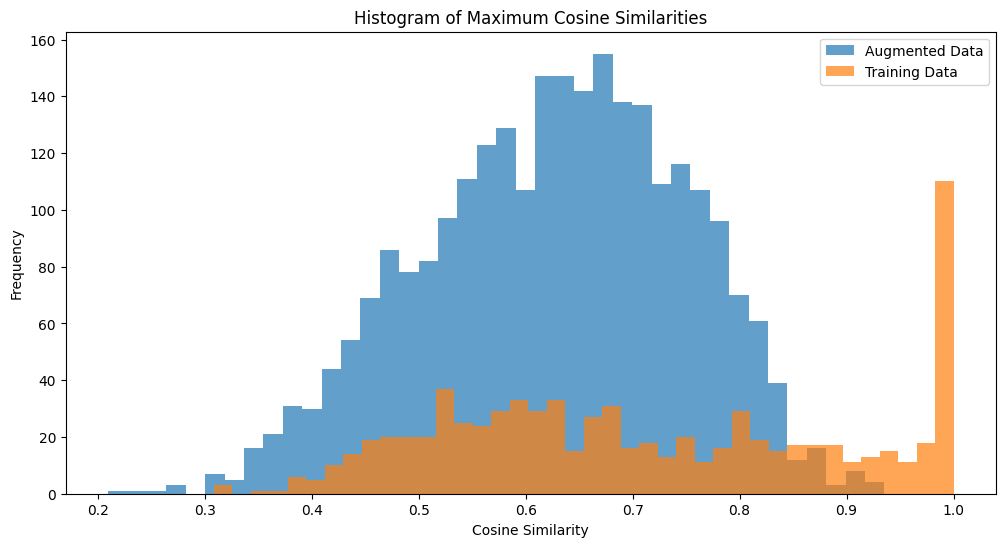

100%|██████████| 788/788 [00:00<00:00, 1091.81it/s]


Augmented Data - Maximum Similarities
Mean: 0.5104, Standard Deviation: 0.1315

Training Data - Maximum Similarities
Mean: 0.7150, Standard Deviation: 0.1853


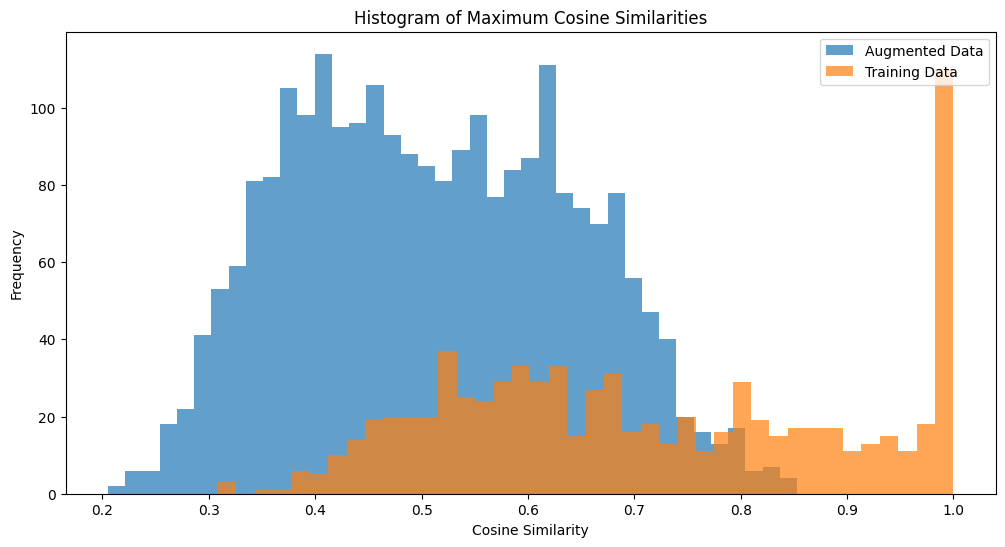

In [ ]:
similarity_score = []
augmented_datasets = [aug_embeddings, aug1_embeddings, aug2_embeddings, aug3_embeddings, aug4_embeddings, aug5_embeddings, aug6_embeddings]
for i in augmented_datasets:
  mean, std = similarity_analysis(i)
  similarity_score.append([mean, std])

In [ ]:
augmented_datasets_names = ['aug_embeddings', 'aug1_embeddings', 'aug2_embeddings', 'aug3_embeddings', 'aug4_embeddings', 'aug5_embeddings', "aug6_embedddings"]
df = pd.DataFrame(similarity_score, columns=['Mean Similarity', 'Std Dev Similarity'])
df.insert(0, 'Dataset', augmented_datasets_names)
df

,Dataset,Mean Similarity,Std Dev Similarity
0,aug_embeddings,0.582628,0.130311
1,aug1_embeddings,0.696593,0.112168
2,aug2_embeddings,0.679055,0.129066
3,aug3_embeddings,0.693835,0.124471
4,aug4_embeddings,0.711473,0.116539
5,aug5_embeddings,0.625738,0.121862
6,aug6_embedddings,0.510360,0.131547


#### Now that we have the sentence embeddings for each sentence without their NER Tags, we can try to see if our basic classifiers can identify the augmented sentences from the seed dataset.

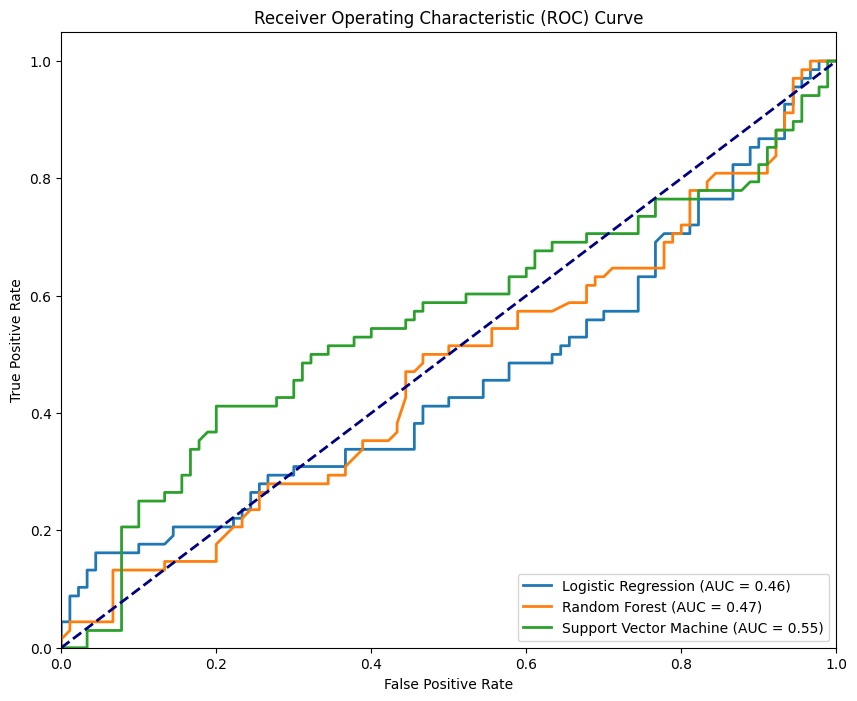

Logistic Regression: Accuracy = 0.46, AUC = 0.46
Random Forest: Accuracy = 0.50, AUC = 0.47
Support Vector Machine: Accuracy = 0.49, AUC = 0.55


In [ ]:
# Testing Classification on Train Dataset
X = train_embeddings
y = [0 for i in range(len(X)-370)] + [1 for i in range(370)]
X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True)
}

auc_scores = {}
accuracy_scores = {}
plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    accuracy_scores[name] = accuracy
    auc_scores[name] = auc_score

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

for name in classifiers:
    print(f"{name}: Accuracy = {accuracy_scores[name]:.2f}, AUC = {auc_scores[name]:.2f}")

In [ ]:
def classification_test(aug_embeddings):
  all_embeddings = []
  for i in train_embeddings:
    all_embeddings.append(i)
  for i in aug_embeddings:
    all_embeddings.append(i)


  X = all_embeddings
  y = [0 for i in range(len(train_embeddings))] + [1 for i in range(len(aug_embeddings))]
  X, y = shuffle(X, y, random_state=42)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  classifiers = {
      "Logistic Regression": LogisticRegression(),
      "Random Forest": RandomForestClassifier(),
      "Support Vector Machine": SVC(probability=True)
  }

  auc_scores = {}
  accuracy_scores = {}
  plt.figure(figsize=(10, 8))

  for name, clf in classifiers.items():
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      y_pred_prob = clf.predict_proba(X_test)[:, 1]

      accuracy = accuracy_score(y_test, y_pred)
      auc_score = roc_auc_score(y_test, y_pred_prob)
      accuracy_scores[name] = accuracy
      auc_scores[name] = auc_score

      fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
      roc_auc = auc(fpr, tpr)

      plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

  for name in classifiers:
      print(f"{name}: Accuracy = {accuracy_scores[name]:.2f}, AUC = {auc_scores[name]:.2f}")

  return accuracy_scores, auc_scores

  0%|          | 0/7 [00:00<?, ?it/s]

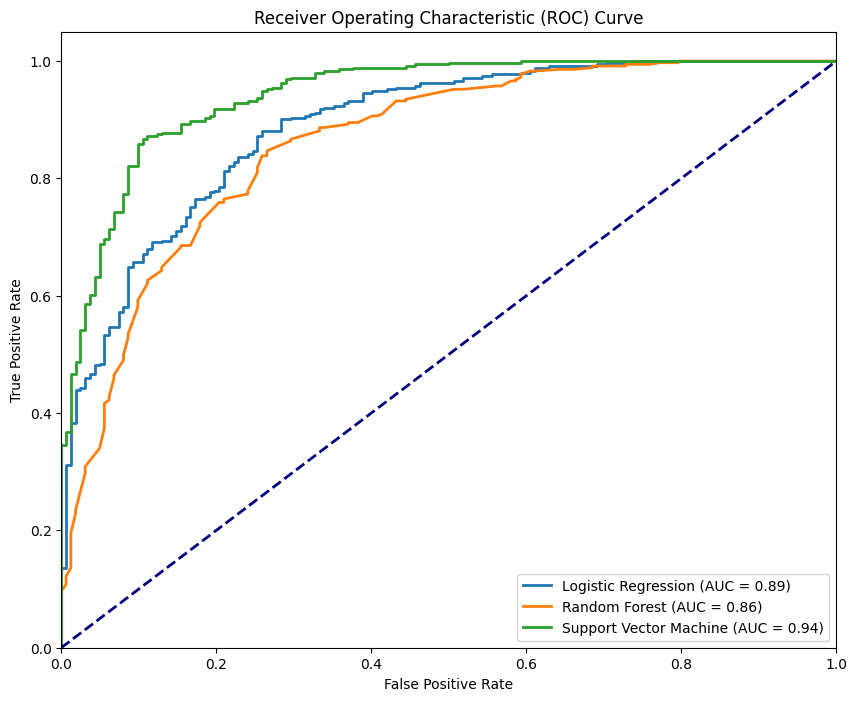

 14%|█▍        | 1/7 [00:05<00:31,  5.28s/it]

Logistic Regression: Accuracy = 0.82, AUC = 0.89
Random Forest: Accuracy = 0.78, AUC = 0.86
Support Vector Machine: Accuracy = 0.88, AUC = 0.94


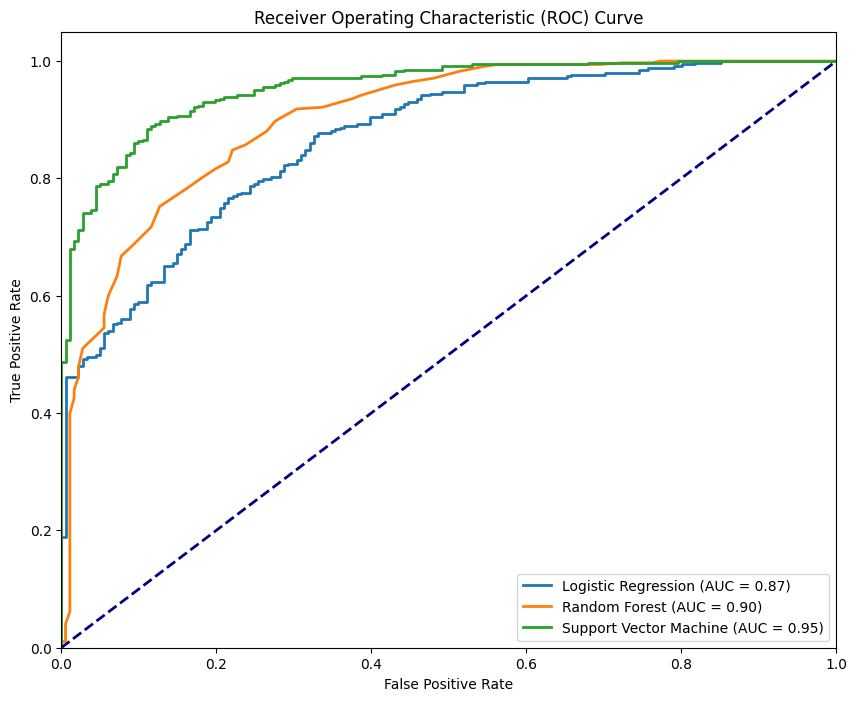

 29%|██▊       | 2/7 [00:11<00:29,  5.81s/it]

Logistic Regression: Accuracy = 0.78, AUC = 0.87
Random Forest: Accuracy = 0.79, AUC = 0.90
Support Vector Machine: Accuracy = 0.86, AUC = 0.95


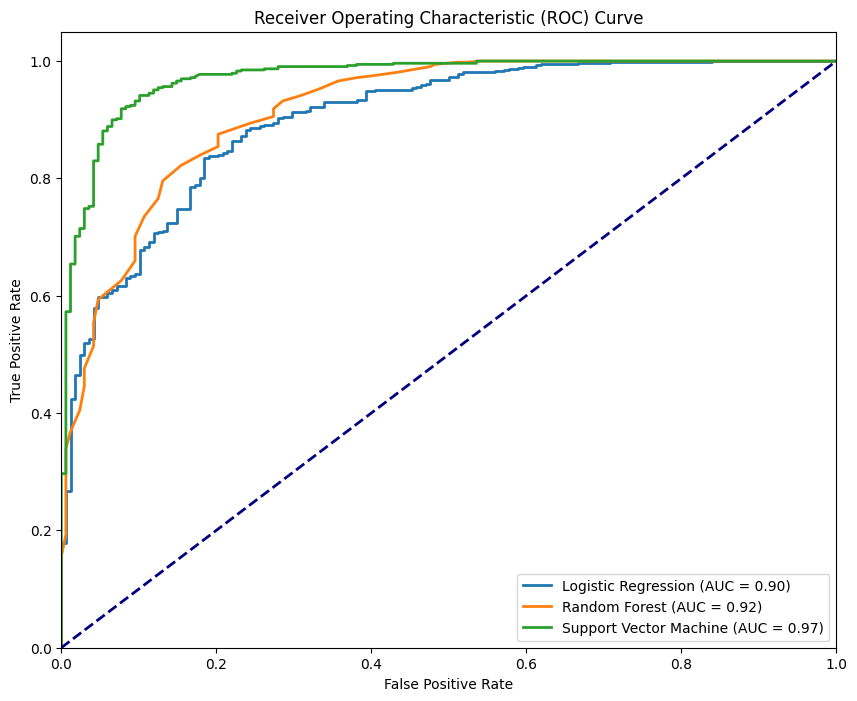

 43%|████▎     | 3/7 [00:20<00:28,  7.17s/it]

Logistic Regression: Accuracy = 0.85, AUC = 0.90
Random Forest: Accuracy = 0.84, AUC = 0.92
Support Vector Machine: Accuracy = 0.91, AUC = 0.97


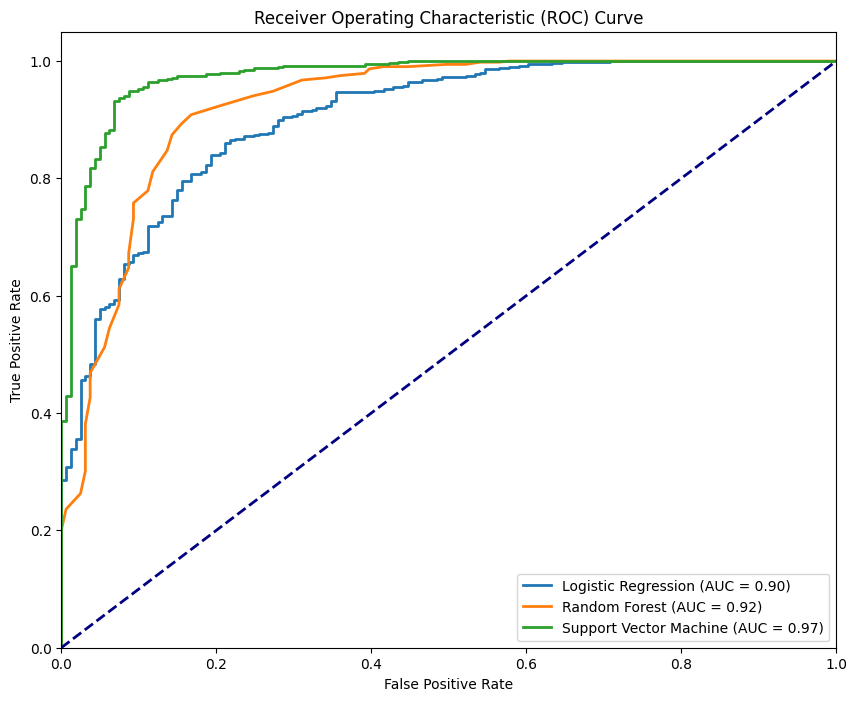

 57%|█████▋    | 4/7 [00:28<00:23,  7.74s/it]

Logistic Regression: Accuracy = 0.85, AUC = 0.90
Random Forest: Accuracy = 0.84, AUC = 0.92
Support Vector Machine: Accuracy = 0.90, AUC = 0.97


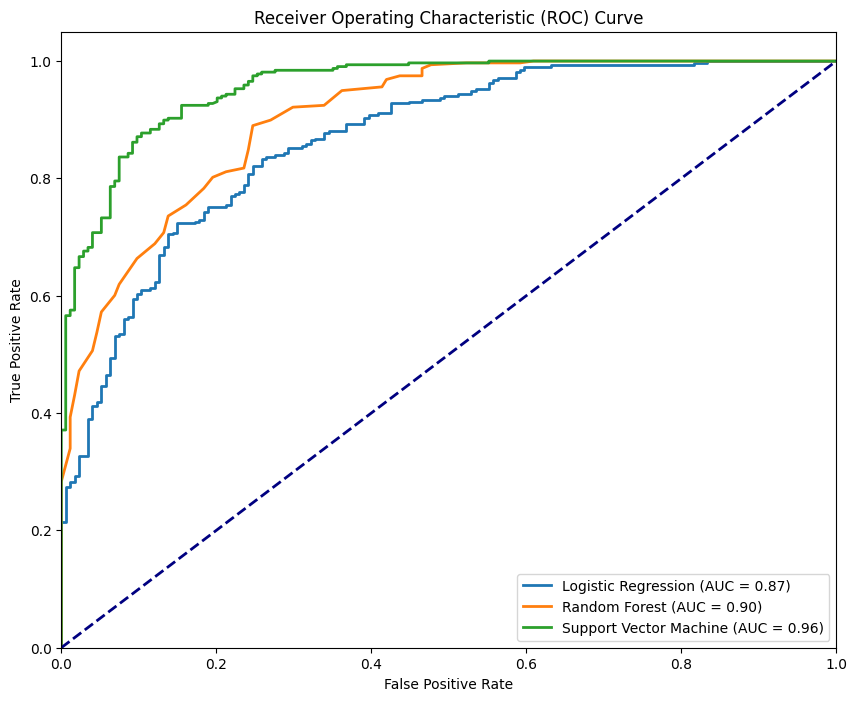

 71%|███████▏  | 5/7 [00:34<00:13,  6.92s/it]

Logistic Regression: Accuracy = 0.78, AUC = 0.87
Random Forest: Accuracy = 0.83, AUC = 0.90
Support Vector Machine: Accuracy = 0.88, AUC = 0.96


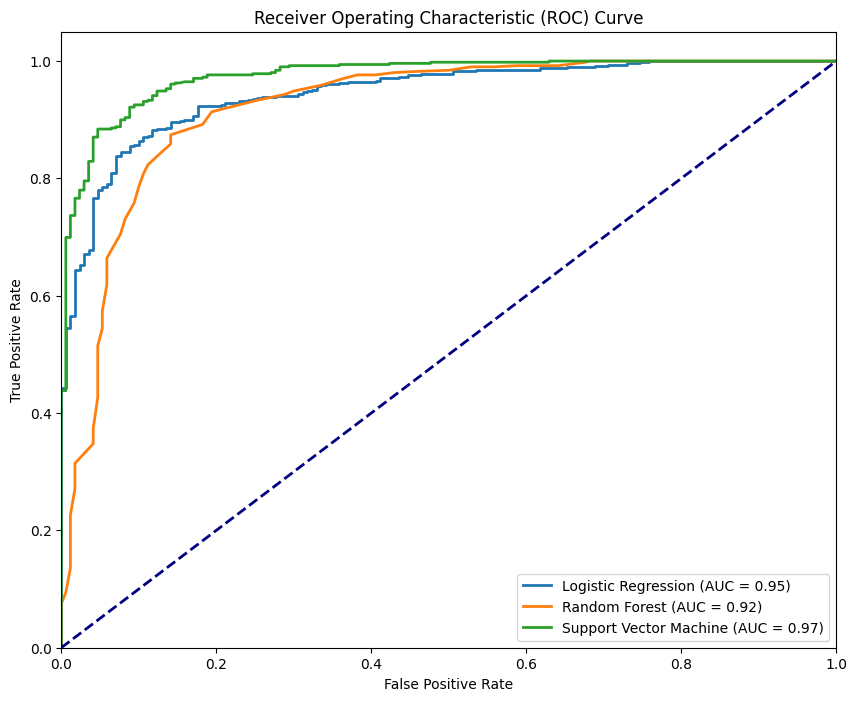

 86%|████████▌ | 6/7 [00:42<00:07,  7.24s/it]

Logistic Regression: Accuracy = 0.87, AUC = 0.95
Random Forest: Accuracy = 0.84, AUC = 0.92
Support Vector Machine: Accuracy = 0.92, AUC = 0.97


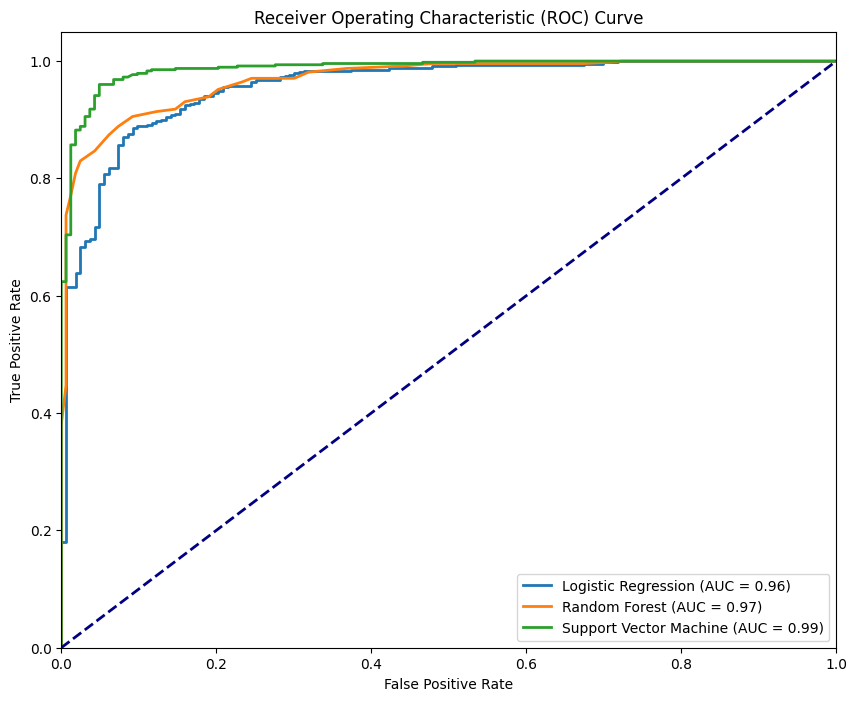

100%|██████████| 7/7 [00:49<00:00,  7.11s/it]

Logistic Regression: Accuracy = 0.91, AUC = 0.96
Random Forest: Accuracy = 0.84, AUC = 0.97
Support Vector Machine: Accuracy = 0.95, AUC = 0.99


In [ ]:
classification_scores = []
augmented_datasets = [aug_embeddings, aug1_embeddings, aug2_embeddings, aug3_embeddings, aug4_embeddings, aug5_embeddings, aug6_embeddings]
for i in tqdm(augmented_datasets):
  a, b = classification_test(i)
  classification_scores.append(list(a.values())+list(b.values()))

In [ ]:
augmented_datasets_names = ['aug_embeddings', 'aug1_embeddings', 'aug2_embeddings', 'aug3_embeddings', 'aug4_embeddings', 'aug5_embeddings', 'aug6_embeddings']
df = pd.DataFrame(classification_scores, columns=['Logistic Regression Accuracy', 'Random Forest Accuracy', "SVM Accuracy", "Logistic Regression AUC", "Random Forest AUC", "SVM AUC"])
df.insert(0, 'Dataset', augmented_datasets_names)
df

,Dataset,Logistic Regression Accuracy,Random Forest Accuracy,SVM Accuracy,Logistic Regression AUC,Random Forest AUC,SVM AUC
0,aug_embeddings,0.817476,0.776699,0.879612,0.889518,0.860674,0.942468
1,aug1_embeddings,0.778626,0.793893,0.864504,0.867081,0.902324,0.954174
2,aug2_embeddings,0.849354,0.836442,0.905308,0.901071,0.917415,0.971881
3,aug3_embeddings,0.849854,0.839650,0.897959,0.902372,0.923999,0.974102
4,aug4_embeddings,0.782520,0.827236,0.884146,0.866894,0.904468,0.956508
5,aug5_embeddings,0.871870,0.836524,0.921944,0.945880,0.921807,0.974639
6,aug6_embeddings,0.907668,0.840376,0.951487,0.956166,0.968694,0.987318


#### Analysis of NER Tags

In [ ]:
def NER_tags(aug):
  train_tags = []
  aug_tags = []

  for i in range(len(train[0])):
    for j in train[1][i]:
      train_tags.append([train[0][i][j['start']:j['end']], j['label']])

  for i in range(len(aug[0])):
    for j in aug[1][i]:
      aug_tags.append([aug[0][i][j['start']:j['end']], j['label']])

  temp = []
  for i in train_tags:
    temp.append(i[1])

  original_tags = set(temp)

  for k in original_tags:
    specific_tag = []
    for i in train_tags:
      if i[1] == k:
        specific_tag.append(i[0])

    specific_tag_aug = []
    for i in aug_tags:
      if i[1] == k:
        specific_tag_aug.append(i[0])

    specific_tag_set = set(specific_tag)
    specific_tag_aug_set = set(specific_tag_aug)

    plt.figure(figsize=(8, 8))
    venn = venn2([specific_tag_set, specific_tag_aug_set], ('Original Dataset', 'Augmented Dataset'))
    plt.title('Venn Diagram of {} Tags'.format(k))
    plt.show()

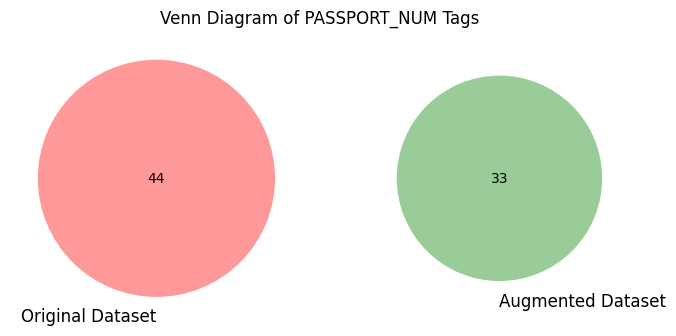

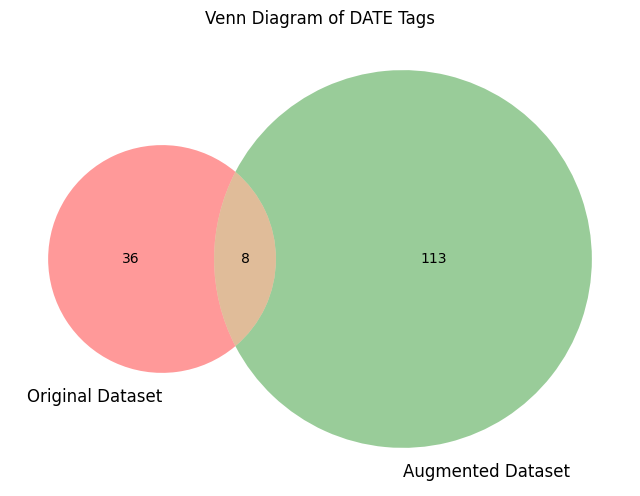

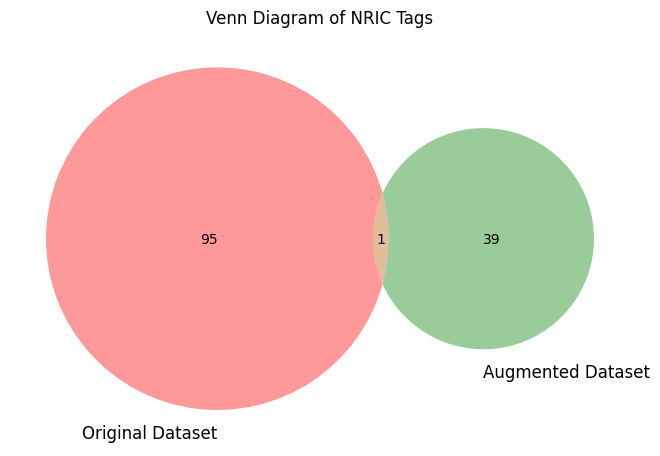

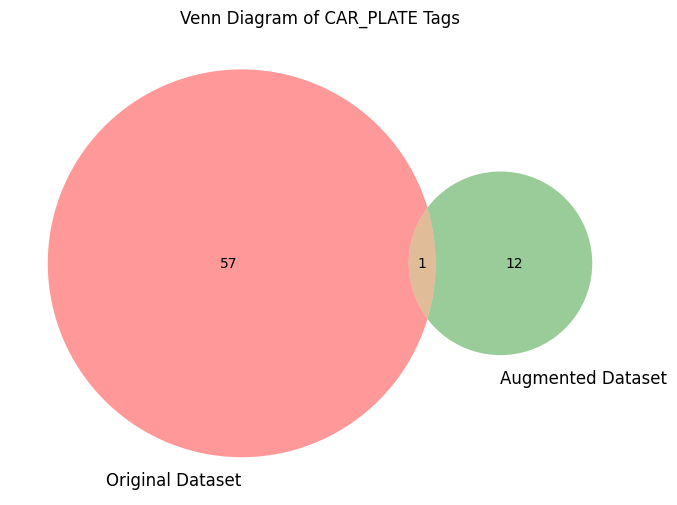

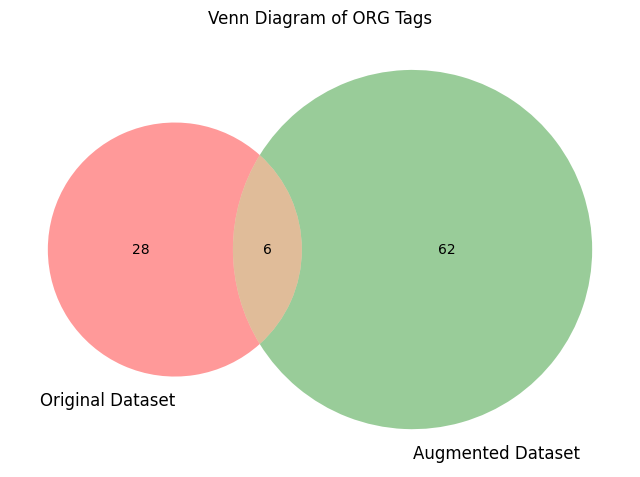

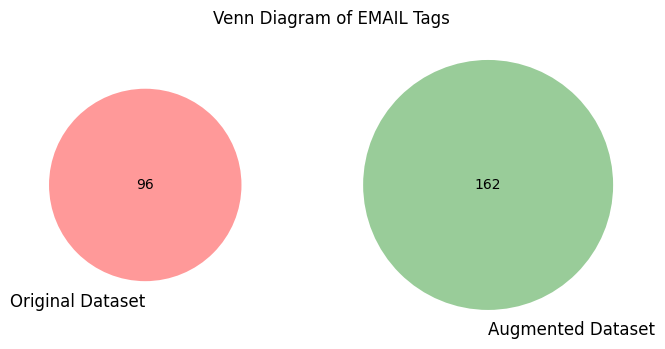

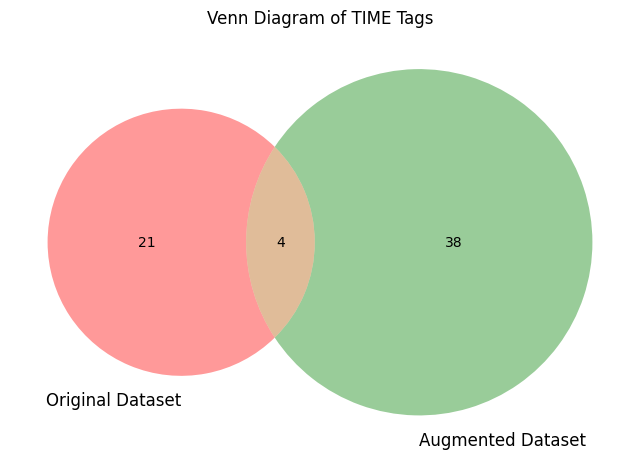

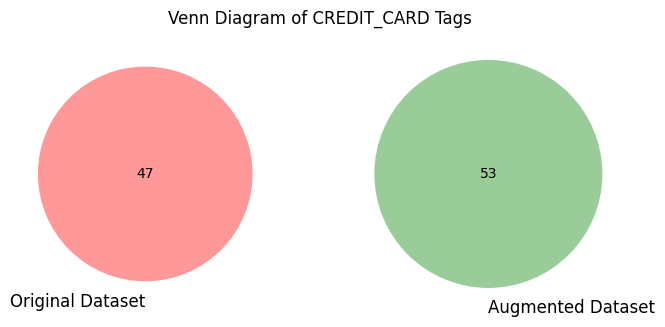

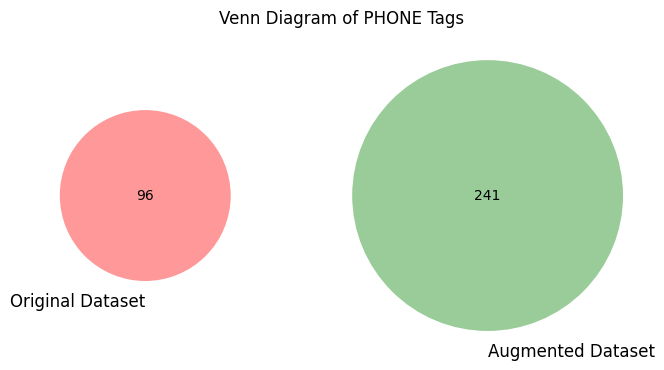

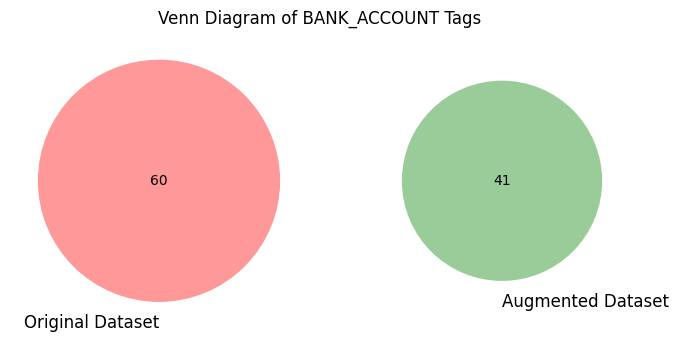

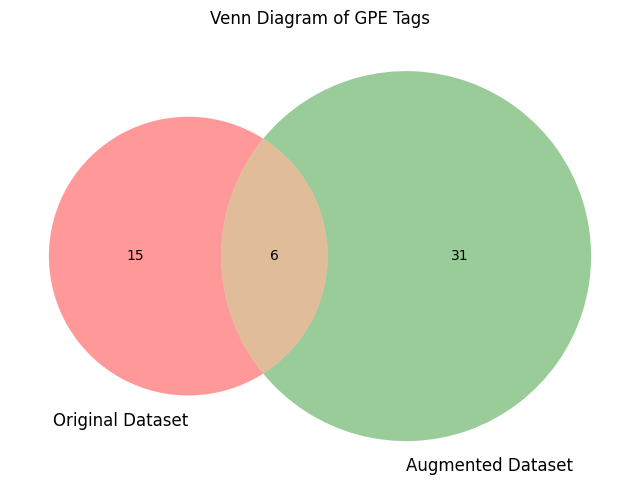

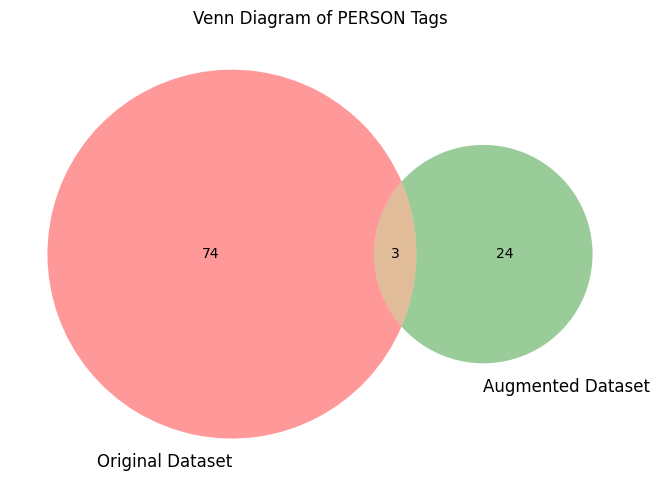

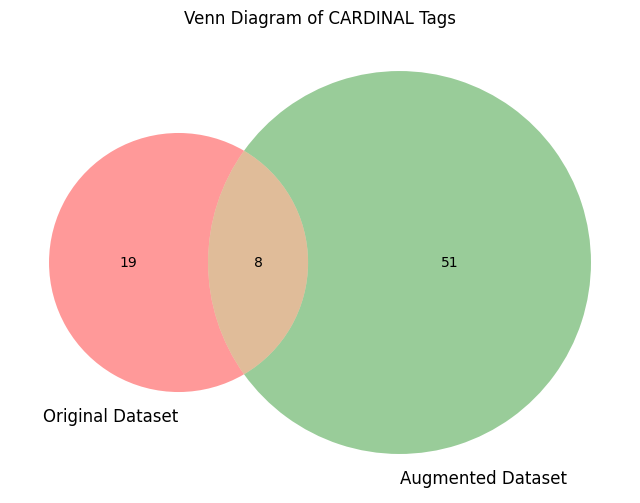

--------------------------------------------


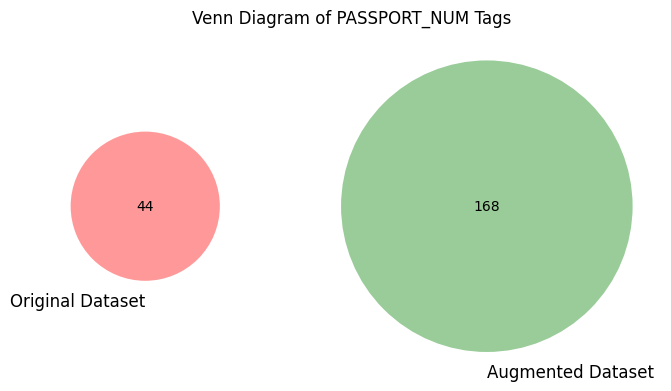

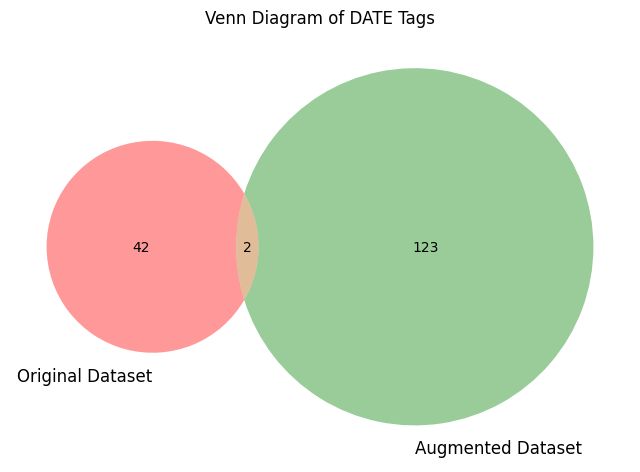

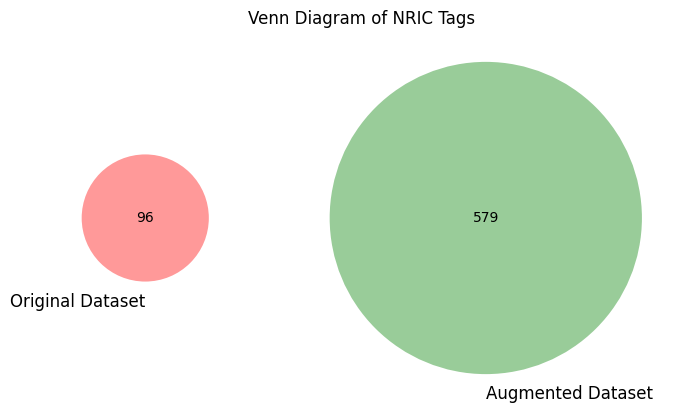

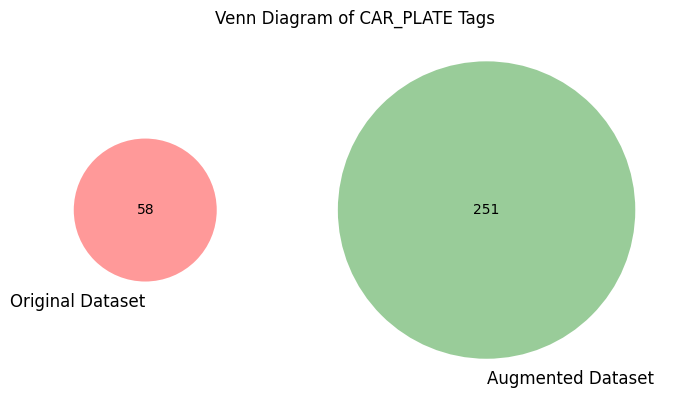

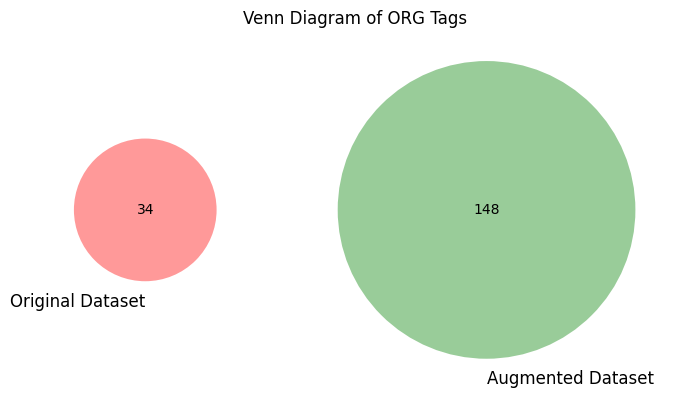

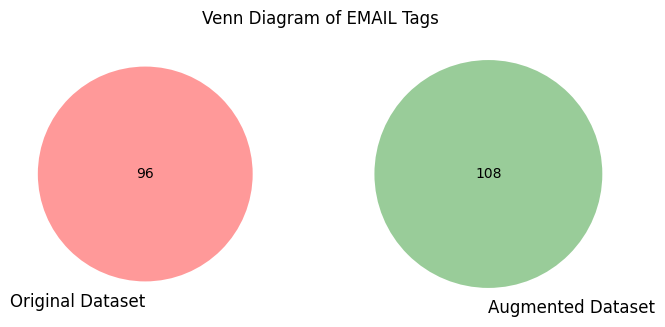

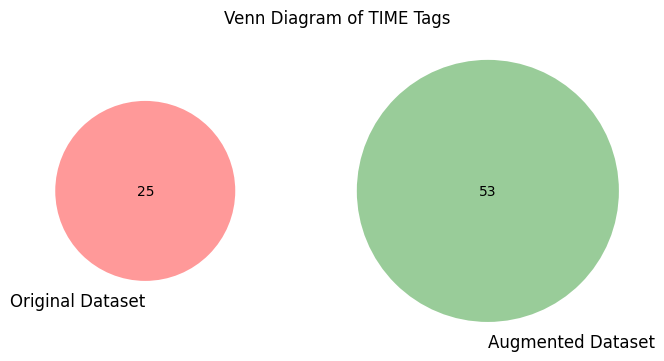

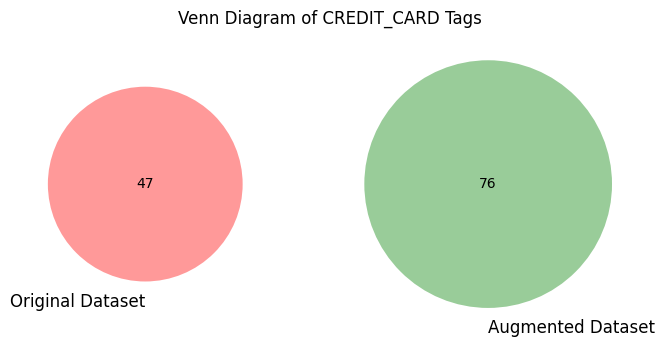

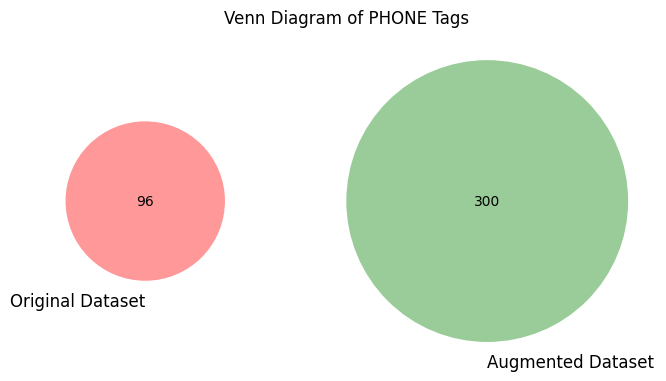

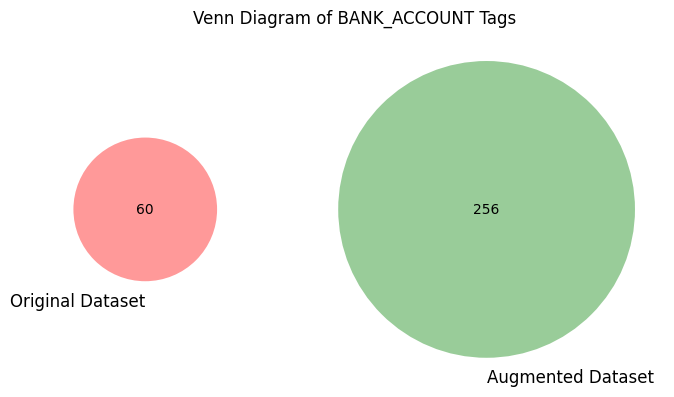

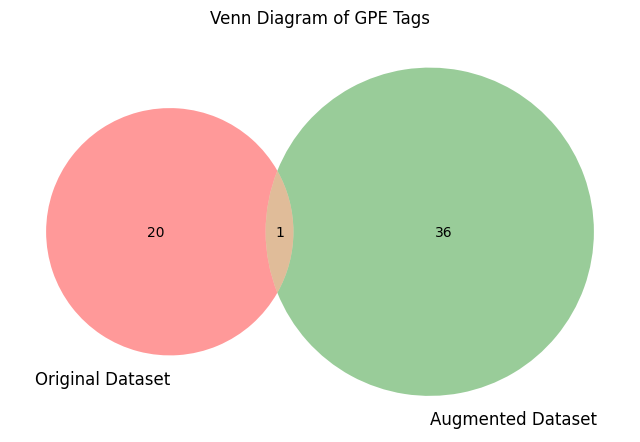

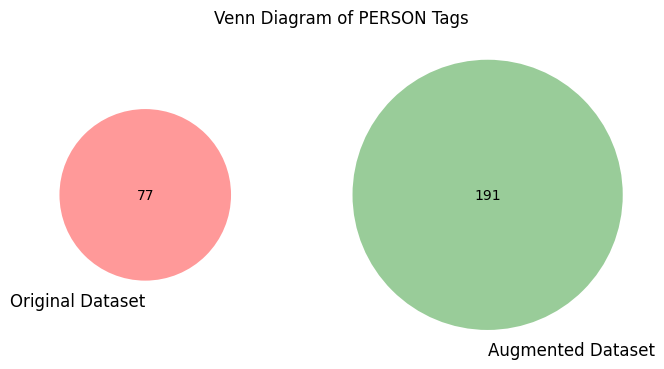

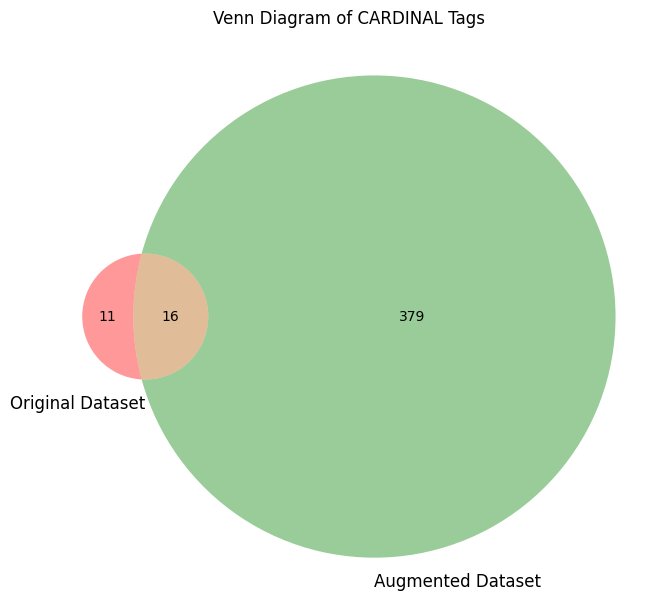

--------------------------------------------


In [ ]:
for i in [aug, aug5]:
  NER_tags(i)
  print("--------------------------------------------")

In [ ]:
import pandas as pd

def NER_tags_count(train, aug_list):
    results = []

    # Extract original tags from the training set
    train_tags = []
    for i in range(len(train[0])):
        for j in train[1][i]:
            train_tags.append([train[0][i][j['start']:j['end']], j['label']])

    # Get unique tags from the training set
    original_tags = set(tag[1] for tag in train_tags)

    for aug in aug_list:
        aug_tags = []
        for i in range(len(aug[0])):
            for j in aug[1][i]:
                aug_tags.append([aug[0][i][j['start']:j['end']], j['label']])

        # Count the number of unique tags in the augmented dataset
        unique_tag_counts = {tag: 0 for tag in original_tags}
        for tag in original_tags:
            specific_tag_aug = [i[0] for i in aug_tags if i[1] == tag]
            unique_tag_counts[tag] = len(set(specific_tag_aug))

        results.append(unique_tag_counts)

    return results

results = NER_tags_count(train, [train, aug, aug1, aug2, aug3, aug4, aug5, aug6])

# Create DataFrame from results
df = pd.DataFrame(results, index=[f'aug_{i}' for i in range(8)])
df.index.name = 'Dataset'
df

,PASSPORT_NUM,DATE,NRIC,CAR_PLATE,ORG,EMAIL,TIME,CREDIT_CARD,PHONE,BANK_ACCOUNT,GPE,PERSON,CARDINAL
Dataset,,,,,,,,,,,,,
aug_0,44,44,96,58,34,96,25,47,96,60,21,77,27
aug_1,33,121,40,13,68,162,42,53,241,41,37,27,59
aug_2,144,41,369,260,44,85,22,52,217,282,27,51,50
aug_3,142,49,591,317,44,88,37,70,332,258,36,52,50
aug_4,111,50,609,209,49,105,43,27,405,285,36,52,50
aug_5,98,39,357,198,47,100,20,52,213,234,27,50,50
aug_6,168,125,579,251,148,108,53,76,300,256,37,191,395
aug_7,91,164,413,225,177,92,50,59,290,194,50,243,480
